<a href="https://colab.research.google.com/github/MaximeGloesener/HandsOnAI-Challenge1/blob/master/Challenge1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Hardware Informations (GPU)**

In [3]:
!/opt/bin/nvidia-smi
!rm -rf sample_data

/bin/bash: /opt/bin/nvidia-smi: No such file or directory


In [33]:
!pip install ImageHash

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached ImageHash-4.3.1-py2.py3-none-any.whl (296 kB)


# **2. Importation of librairies**

In [4]:
from IPython.display import Image, HTML, display
from matplotlib import pyplot as plt
import numpy as np 
import os
import cv2
import csv
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing import image
from keras.models import Model, load_model
from keras import backend as K
from keras.applications.vgg16 import VGG16, preprocess_input #224*224
from keras.applications.xception import Xception, preprocess_input, decode_predictions #299*299
from keras.applications.mobilenet import MobileNet, preprocess_input, decode_predictions #224*224
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import categorical_crossentropy
from keras.layers import Dense, GlobalAveragePooling2D, Activation, Flatten, Dropout
from keras.callbacks import ModelCheckpoint, EarlyStopping
import math
import argparse
import matplotlib
import imghdr
import pickle as pkl
import datetime
from cycler import cycler
from PIL import Image, ImageEnhance
from google.colab import files
from tqdm import tqdm
print("Tensorflow version: "+tf.__version__)
print("Keras version: " + tf.keras.__version__)

Tensorflow version: 2.9.2
Keras version: 2.9.0


#**3. Download of training datasets "FIRE_DATABASE_X"**

In [6]:
bases_path_after="bases"
if os.path.exists(bases_path_after) == False:
    os.makedirs(bases_path_after)

In [7]:
!rm -rf FIRE_DATABASE_1.tar
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_1.tar
!tar xf FIRE_DATABASE_1.tar -C 'bases' --one-top-level
!rm FIRE_DATABASE_1.tar

--2022-10-17 19:17:38--  https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_1.tar
Resolving cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)... 193.190.209.220
Connecting to cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 466772992 (445M) [application/octet-stream]
Saving to: ‘FIRE_DATABASE_1.tar’

FIRE_DATABASE_1.tar 100%[===================>] 445.15M  28.9MB/s    in 16s     

2022-10-17 19:17:55 (27.7 MB/s) - ‘FIRE_DATABASE_1.tar’ saved [466772992/466772992]



In [8]:
!rm -rf FIRE_DATABASE_2.tar
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_2.tar
!tar xf FIRE_DATABASE_2.tar -C 'bases' --one-top-level
!rm FIRE_DATABASE_2.tar

--2022-10-17 19:17:57--  https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_2.tar
Resolving cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)... 193.190.209.220
Connecting to cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1163223040 (1.1G) [application/octet-stream]
Saving to: ‘FIRE_DATABASE_2.tar’

FIRE_DATABASE_2.tar 100%[===================>]   1.08G  29.0MB/s    in 39s     

2022-10-17 19:18:37 (28.3 MB/s) - ‘FIRE_DATABASE_2.tar’ saved [1163223040/1163223040]



In [9]:
!rm -rf FIRE_DATABASE_3.tar
!rm -rf sample_data
!wget https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_3.tar
!tar xf FIRE_DATABASE_3.tar -C 'bases' --one-top-level
!rm FIRE_DATABASE_3.tar

--2022-10-17 19:18:42--  https://cluster.ig.umons.ac.be/HackIA21/databases/FIRE_DATABASE_3.tar
Resolving cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)... 193.190.209.220
Connecting to cluster.ig.umons.ac.be (cluster.ig.umons.ac.be)|193.190.209.220|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 471111680 (449M) [application/octet-stream]
Saving to: ‘FIRE_DATABASE_3.tar’

FIRE_DATABASE_3.tar 100%[===================>] 449.29M  26.7MB/s    in 23s     

2022-10-17 19:19:06 (19.2 MB/s) - ‘FIRE_DATABASE_3.tar’ saved [471111680/471111680]



Important de tester les doublons en utilisant un hash cryptographique qui comparer les images pixels par pixels. Avec un hash robuste, on trouve des faux doublons. Le hash robuste permet de détecter les doublons si resize/légère modifiction mais ce n'est pas le cas ici dans les datasets. 

In [28]:
def read_image(file_name):
  """
  Fonction qui prend en entrée une path d'image et qui return RGB (utile pour plot)
  """
  img = cv2.imread(file_name, 3)
  b,g,r = cv2.split(img)
  rgb_image = cv2.merge([r,g,b])
  return rgb_image

def plot(images, noms):
  f, axarr = plt.subplots(1,len(images))
  for i in range(len(images)):
    axarr[i].imshow(images[i])
    axarr[i].title.set_text(noms[i])


/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


Il y a 20 doublons dans le dataset = 1.3333333333333335% des données


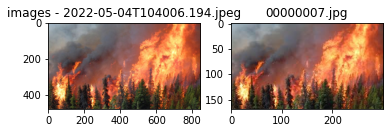

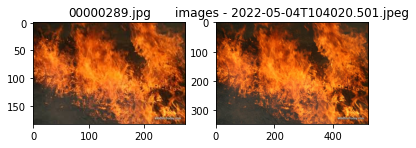

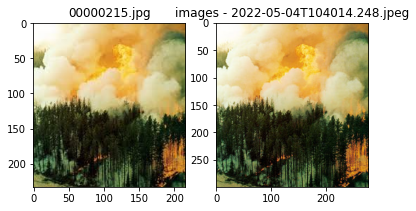

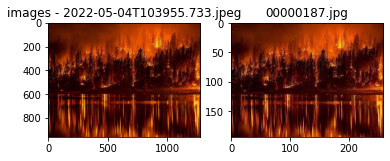

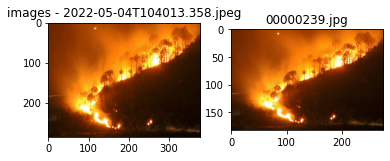

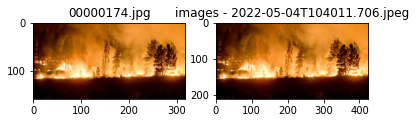

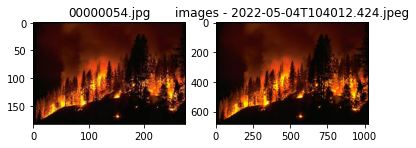

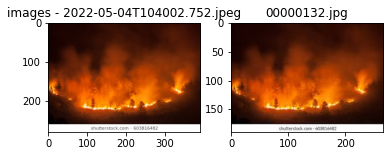

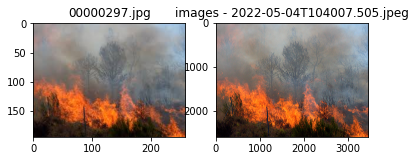

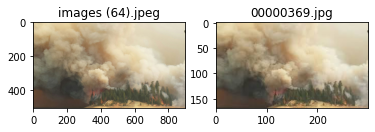

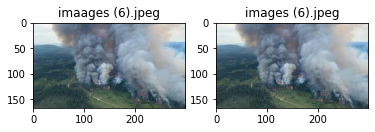

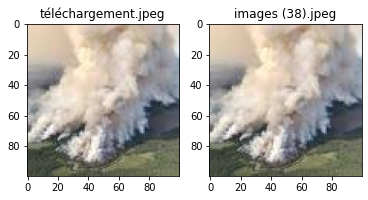

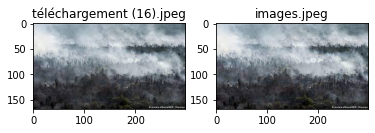

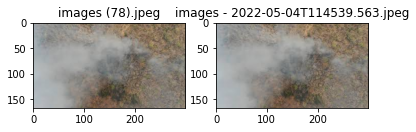

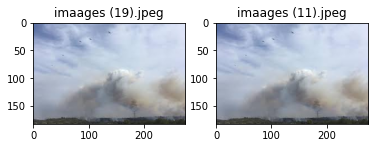

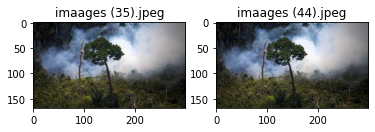

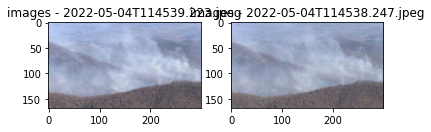

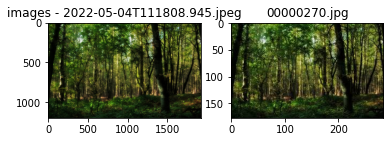

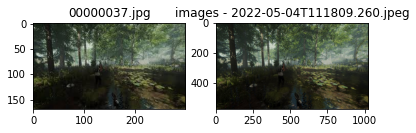

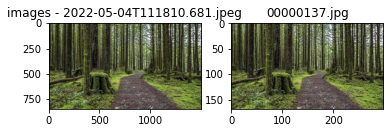

In [46]:
import imagehash
# Analyse des données
# On sait que dans les datasets, il y a parfois plusieurs fois la même image
# But : analyser chaque dataset et trouver le nombre d'images en doublons
def analyse_dataset(folder_name, affichage = False):
  """
  Fonction qui prend en entrée le directory d'un dataset et qui va chercher les images qui sont présentes plusieurs fois pour ce même dataset
  Affichage = True si on veut plot les images qui sont en doubles et leur nom
  Return: - le nombre de doublons dans un dataset
          - le pourcentage de doublons
  """
  img_hashes = dict()
  total = 0
  doublons = 0

  for dir in os.listdir(folder_name):
    for image in os.listdir(os.path.join(folder_name, dir)):
      total += 1
      image = os.path.join(os.getcwd(), folder_name, dir, image)
      hash = imagehash.dhash(Image.open(image))
      if hash in img_hashes:
        doublons += 1
        #print(f'{image} doublons de {img_hashes[hash]}')
        if affichage:
          i = read_image(image) 
          x = read_image(img_hashes[hash])
          plot([x,i],[image.split("/")[-1], img_hashes[hash].split("/")[-1]])
      else:
        img_hashes[hash] = image

  return doublons, doublons/total*100

d1, p1= analyse_dataset("/content/bases/FIRE_DATABASE_1/")
d2, p2, = analyse_dataset("/content/bases/FIRE_DATABASE_2/")
d3, p3 = analyse_dataset("/content/bases/FIRE_DATABASE_3/", affichage = True)
print('DATASET 1 ')
print(f'Il y a {d1} doublons dans le dataset = {p1}% des données')
print('DATASET 2 ')
print(f'Il y a {d2} doublons dans le dataset = {p2}% des données')
print('DATASET 3 ')
print(f'Il y a {d3} doublons dans le dataset = {p3}% des données')


In [60]:
# Créer un seul dataset à partir des 3 en ne prenant en compte que des images uniques (supprimer tous les doublons)
def make_dataset(base_directory):
  !rm -rf all_data
  directory = 'all_data'
  directory_path = os.path.join(os.getcwd(), directory)
  # créer un nouveau directory all_data s'il n'existe pas déjà
  if not os.path.exists(directory_path):
    os.mkdir(directory_path)
    os.mkdir(os.path.join(directory_path, "fire"))
    os.mkdir(os.path.join(directory_path, "no_fire"))
    os.mkdir(os.path.join(directory_path, "start_fire"))

  images_hash = set()
  for dir in os.listdir(base_directory):
    for dir2 in os.listdir(os.path.join(base_directory,dir)):
      for img in os.listdir(os.path.join(base_directory,dir,dir2)):
        path = os.path.join(os.getcwd(), base_directory, dir, dir2, img)
        hash = imagehash.dhash(Image.open(path))
        if hash not in images_hash:
          images_hash.add(hash)
          cv2.imwrite(os.path.join(directory_path, dir2, img), cv2.imread(path))

make_dataset("bases")

/usr/local/lib/python3.7/dist-packages/PIL/TiffImagePlugin.py:770: UserWarning: Possibly corrupt EXIF data.  Expecting to read 20 bytes but only got 19. Skipping tag 36867
  " Skipping tag %s" % (size, len(data), tag)


In [58]:
print(len(os.listdir("/content/all_data")))

1278


#**4. Cretate the labels file "classes.txt"**

In [ ]:
!printf '%s\n' 'fire' 'no_fire' 'start_fire'> classes.txt

#**5. Training parameters and selectioon of Pretrained model**

In [ ]:
nb_classes = 3
nbr_batch_size=8 #@param [1,2,4,8,16,32,64,128] {type:"raw"}
dataset_path = "bases"
input_dim=224 #@param [224,299] {type:"raw"}  
dataset_name='FIRE_DATABASE_1' #@param ["FIRE_DATABASE_1","FIRE_DATABASE_2","FIRE_DATABASE_3","Personal"]

dataset_path = os.path.join('bases/', dataset_name)
classes_path = "classes.txt"
csv_path = 'result.csv'
epochs = 10 #@ param {type:"slider", min:5, max:100, step:5}

seed = 1
result_path='results/'
log_path='logs'

classifier = "ResNet50" #@param ["ResNet50","VGG19","Xception","MobileNet","DenseNet169"] {type:"string"}
result_path = 'results/'+classifier
log={
    'epochs':epochs,
    'batch_size':nbr_batch_size,
    'val_loss':-1,
    'val_acc':-1,
}

# **6. Get the number of classes**

In [ ]:

# Get the class names
with open(classes_path, 'r') as f:
    classes = f.readlines()
    classes = list(map(lambda x: x.strip(), classes))
num_classes = len(classes)

# **8. Selection and configuration of the training dataset**

In [ ]:

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
	dataset_path,                     # Path of the dataset
	validation_split=0.2,             # Data division : validation (20%), train (80%)
	subset="training",                # Selection of training data
	seed=42,                          # Initialization of random generator (for permutations)
	image_size=(224,224),    # Input size of images
	batch_size=nbr_batch_size,        # Batch_size
  label_mode="categorical"     # Conversion to One-Hot format
)

Found 1500 files belonging to 3 classes.
Using 1200 files for training.


#**9. Selection and configuration of the validation dataset**

In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
	dataset_path,                     # Path of the dataset
	validation_split=0.2,             # Data division : validation (20%), train (80%)
	subset="validation",                # Selection of validation data
	seed=42,                          # Initialization of random generator (for permutations)
	image_size=(224,224),    # Input size of images
	batch_size=nbr_batch_size,        # Batch_size
  label_mode="categorical"     # Conversion to One-Hot format
)

Found 1500 files belonging to 3 classes.
Using 300 files for validation.


# **10. Download the pretrained model**

In [ ]:
base_model = Xception(include_top = False, weights ='imagenet',input_shape = (input_dim,input_dim,3))
model = base_model.output
model = Flatten()(model)
model = Dense(128,activation='relu')(model)
model = Dropout(0.8)(model)
model = Dense(64,activation = 'relu')(model)
model = Dropout(0.4)(model)
predictions = Dense(num_classes, activation = 'softmax')(model)
model = Model(inputs=base_model.inputs, outputs=predictions)

83683744/83683744 [==============================] - 0s 0us/step


# **13. Model training**

In [ ]:
# pour permettre le ré-entrainement des couches
for layer in model.layers:
    layer.trainable = True
def adapt_learning_rate(epoch):
    return 0.001/epoch
# recompiler le modèle
opt = keras.optimizers.SGD(learning_rate=0.0001,decay=1e-6)
opt2 = keras.optimizers.Adam(lr=0.0001)
opt3 = keras.optimizers.RMSprop(learning_rate = 0.0001,decay =1e-6)
model.compile(loss='categorical_crossentropy',optimizer=opt3,metrics=['accuracy'])  


# Création du dossier pour sauvegrader le model
if os.path.exists(result_path) == False:
    os.makedirs(result_path)


keras_callback = [EarlyStopping(monitor='val_loss',patience = 25, verbose = 2)]

history=model.fit(
    train_ds,
    steps_per_epoch=math.ceil(len(train_ds)),
    epochs=epochs,
    validation_data=val_ds,
    validation_steps=math.ceil(len(val_ds)),
    verbose=1,
    #callbacks = keras_callback
)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


150/150 [==============================] - 49s 203ms/step - loss: 1.0074 - accuracy: 0.5758 - val_loss: 0.9749 - val_accuracy: 0.5800
Epoch 2/10
150/150 [==============================] - 31s 200ms/step - loss: 0.5727 - accuracy: 0.7808 - val_loss: 0.5573 - val_accuracy: 0.8167
Epoch 3/10
150/150 [==============================] - 31s 202ms/step - loss: 0.3733 - accuracy: 0.8600 - val_loss: 0.2407 - val_accuracy: 0.9100
Epoch 4/10
150/150 [==============================] - 31s 199ms/step - loss: 0.2758 - accuracy: 0.8917 - val_loss: 0.2864 - val_accuracy: 0.9000
Epoch 5/10
150/150 [==============================] - 31s 201ms/step - loss: 0.2164 - accuracy: 0.8925 - val_loss: 0.2356 - val_accuracy: 0.9067
Epoch 6/10
150/150 [==============================] - 32s 205ms/step - loss: 0.2283 - accuracy: 0.9058 - val_loss: 0.2477 - val_accuracy: 0.8933
Epoch 7/10
150/150 [==============================] - 31s 200ms/step - loss: 0.2503 - accuracy: 0.8942 - val_loss: 0.3474 - val_accuracy: 0.9

#**14. Save your model**


In [ ]:
model.save('test.h5')

#**15. Visualization of training/validation curves**

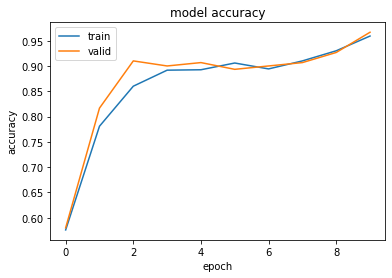

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

#**16. Test the model with a test image**

In [ ]:
filename = "https://www.ecologie.gouv.fr/sites/default/files/styles/standard/public/Feux.png"

1/1 [==============================] - 2s 2s/step
Class Name : fire --- Class Probability: 18.69%
Class Name : no_fire --- Class Probability: 34.67%
Class Name : start_fire --- Class Probability: 46.65%


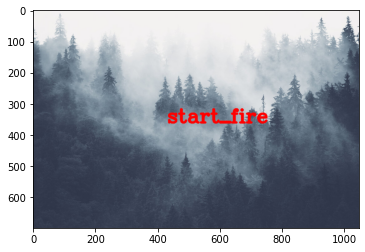

In [ ]:
%matplotlib inline
classes = train_ds.class_names
image_path =  "fog.jpg"
img = Image.open(image_path).convert('RGB')
x = tf.keras.utils.img_to_array(img,data_format='channels_last')
x = tf.keras.preprocessing.image.smart_resize(x, size=(input_dim,input_dim))
x = np.expand_dims(x, axis=0)
# predict
pred = model.predict(x,batch_size=1)[0]

for (pos,prob) in enumerate(pred):
    class_name = classes[pos]
    if (pos == np.argmax(pred)) :
        img = cv2.imread(image_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        font = cv2.FONT_HERSHEY_COMPLEX 
        textsize = cv2.getTextSize(class_name, font, 1, 2)[0]
        textX = (img.shape[1] - textsize[0]) / 2
        textY = (img.shape[0] + textsize[1]) / 2
        cv2.putText(img, class_name, (int(textX)-10, int(textY)), font, 2, (255,0,0), 6, cv2.LINE_AA)
        plt.imshow(img)
    print("Class Name : %s" % (class_name), "---", "Class Probability: %.2f%%" % (prob*100))
plt.show()